In [1]:
import os

from IPython.display import display, Markdown, Image
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

In [2]:
%matplotlib inline

REPO_PATH = os.path.dirname(os.path.dirname(os.path.dirname(os.getcwd())))
TASK_PATH = os.path.join(REPO_PATH, "tasks", "10-vectors.md")
DATA_PATH = os.path.join(os.getcwd(), "1551.gov.ua", "raw")

In [3]:
def show_markdown(path):
    with open(path, 'r') as fh:
        content = fh.read()
    display(Markdown(content))

In [4]:
show_markdown(TASK_PATH)

# Векторні представлення

## Завдання 1

Побудуйте покращений класифікатор, який буде предбачати категорію запиту до служби 1551 з використанням тільки векторів слів (не використовувати інші ознаки, такі як самі слова, нграми і т.д) для всіх категорій.

У якості бейзлайну використайте класифікатор kNN, який ви побудували на практичному.

Зробіть як мінімум 2 ітерації покращення, які можуть полягати у:

- підборі найкращого варіанту векторів з наведених тут: https://lang.org.ua/en/models/#anchor4 або інших (fasttext, Tf-IDF, LDA, ...) Ви навіть можете дотренувати вектори на власній тренувальній множині. Можете також спробувати агрегацію декількох векторів.
- будь-яких видах передпроцесингу і попередньої обробки (фільтрація мови, стопслів, службових частин мови, лематизація, нормалізація, ...)
- побудови векторів документу з використанням таких підходів як pargaraph vectors (doc2vec), ElMo, Universal Sentece Encoder...
- використання довільних алгоритмів класифікації та ансамблів цих алгоритмів
- групуванні категорій (на основі кластеризації або якихось евристик) та побудови багаторівневих класифікаторів

Ваша мета: досягнути такого результату по якості, щоб було не соромно дивитись в очі Кличкові. ;)

## Завдання 2

Візуалізуйте ваші класи з використанням t-SNE. Якщо ви будете використовувати агрегацію категорій, то можете візуалізувати тільки категорії вищого рівня і, для прикладу, одну з них. Якщо ви не будете групувати категорії, то використовуйте для візуалізації найбільш частотні (30-50). Спробуйте досягти достатньо розділеної картинки, експериментуючи з параметрами візуалізації (звісно, якщо ваші вхідні дані дозволять вам це).


## Оцінювання

Оцінка:
- 90 балів за класифікатор (рішення, які будуть мати якість більше 0.8 за macro_average або більше 0.9 за micro_average отримають додаткові 10 балів)
- 10 балів за візуалізацію

Крайній термін: 16.05.2020


## Read data

In [5]:
import re
import gzip
import json

import pandas as pd
import numpy as np

from tqdm import tqdm
from tqdm.contrib.concurrent import process_map
from pathlib import Path
from collections import Counter

In [6]:
import pycld2 as cld2
from langdetect import detect, lang_detect_exception

def lang_detect(x):
    try:
        return detect(x.lower())
    except lang_detect_exception.LangDetectException:
        return ''

def lang_detect_v2(x):
    try:
        x = ''.join(_ for _ in " ".join(x.split()[:100]).lower() if _.isprintable())
        isReliable, textBytesFound, details = cld2.detect(x)
        res = sorted(details, key=lambda x: x[2], reverse=True)[0][1]
        if res == 'un':
            res = detect(x.lower())
        return res
    except:
        return ""

In [7]:
res = []
for file_path in tqdm(Path(DATA_PATH).rglob('*.gz')):
    with gzip.open(file_path, 'rt', encoding='utf8') as zipfile:
        obj = json.load(zipfile)[0]
    res.append(obj)
df = pd.DataFrame(res)

127329it [00:18, 6985.02it/s]


In [8]:
df['manager_name'] = df['CallZManager'].map(lambda x: "" if not re.search(r"\[([\s\w\.]+)\]", x) 
                                                         else re.findall(r"\[([\s\w\.]+)\]", x)[0].strip())
df['entity_name'] = df['CallZManager'].map(lambda x: re.sub(r"\[([\s\w\.]+)\]", "", x))
df['cat_count'] = df['CallZType'].map(df['CallZType'].value_counts().to_dict())
df['word_count'] = df['CallZText'].str.split().map(len)

In [9]:
%%time

lst = process_map(lang_detect, df['CallZText'].values, chunksize=1, max_workers=8)
df['lang'] = lst


CPU times: user 31.4 s, sys: 3.6 s, total: 35 s
Wall time: 2min 15s


In [10]:
df['word_count'].describe()

count    127329.000000
mean         63.134384
std          59.138254
min           0.000000
25%          22.000000
50%          45.000000
75%          84.000000
max         418.000000
Name: word_count, dtype: float64

In [11]:
print(f"Records with > 100 label samples: {df.loc[df.cat_count > 100].shape[0] / df.shape[0] * 100:.2f} %")

Records with > 100 label samples: 89.95 %


In [12]:
df['lang'].value_counts()

uk    69325
ru    56958
        540
bg      330
mk      162
pl        4
ca        2
et        2
en        2
fr        1
sl        1
sk        1
sw        1
Name: lang, dtype: int64

In [13]:
# Counter(" ".join(df['entity_name'].values).lower().split()).most_common(10)

In [14]:
data_uk = df.loc[(df.cat_count > 100) & (df.lang.isin(['uk']))]#[['CallZText', 'CallZType']]
data_ru = df.loc[(df.cat_count > 100) & (df.lang.isin(['ru']))]#[['CallZText', 'CallZType']]
data_uk = data_uk.rename(columns=dict(zip(['CallZText', 'CallZType'], ['text', 'label'])))
data_ru = data_ru.rename(columns=dict(zip(['CallZText', 'CallZType'], ['text', 'label'])))
print(data_uk.shape, data_ru.shape)

(61976, 25) (51667, 25)


In [15]:
data_uk.head()

,StatusTitle,CallZCdate,CallZReply,text,CallZManager,label,CallDate,CallCode,FbId,Enabled,...,PY,showStatus,files,feedfiles,reply,manager_name,entity_name,cat_count,word_count,lang
0,Виконано,2015-07-03 00:00:00,,Добрий день! Відповідно до контрольної картки ...,КП ”УЗН” [Сінцов Геннадій Львович ],Утримання парків та лісопарків у місті Києві,2015-06-18 13:20:58,І-2513,149382,1,...,30.636674,,"[{'id': '81573', 'InOut': '0', 'file': '/feedb...","[{'id': '49925', 'file': '/feedback/fdocs/3201...","{'1436176081': {'id': '103381', 'callid': '320...",Сінцов Геннадій Львович,КП ”УЗН”,399,82,uk
2,Виконано,2013-10-21 00:00:00,,В будинку 29 на вулиці Якуба Коласа відсутнє о...,КП РЕО-5 [Бондар Юрій Іванович],Відсутність опалення,2013-10-17 18:20:15,І-4646,28337,1,...,30.383763,,,,[],Бондар Юрій Іванович,КП РЕО-5,6020,55,uk
3,На доопрацюванні виконавцем,2014-01-28 00:00:00,,"Доброго дня, вимушена звертатися за допомогою ...",ПАТ ”Київенерго” - ТРМ [Фоменко Олександр Вале...,Недостатній тиск ГВП,2014-01-13 14:30:50,І-83,40156,1,...,30.414153,,,"[{'id': '12021', 'file': '/feedback/fdocs/2690...","{'1390476591': {'id': '23506', 'callid': '2690...",Фоменко Олександр Валерійович,ПАТ ”Київенерго” - ТРМ,303,97,uk
6,В роботі,2015-05-27 00:00:00,,Відсутне ГВП (в об’яві - на невизначений термін),ПАТ ”Київенерго” - ЖТЕ [Фоменко Олександр Вале...,Відсутність ГВП,2015-05-12 17:43:50,І-1871,136934,1,...,30.432559,,,,[],Фоменко Олександр Валерійович,ПАТ ”Київенерго” - ЖТЕ,13273,8,uk
8,Чекає на перевіку контр.відділом,2014-10-06 00:00:00,,Доброго дня! Вже неможливо терпіти відсутність...,ПАТ ”Київенерго” - ТРМ [Фоменко Олександр Вале...,Відсутність ГВП,2014-09-21 12:10:28,І-2631,74345,1,...,30.63972,,,"[{'id': '21895', 'file': '/feedback/fdocs/2875...",[],Фоменко Олександр Валерійович,ПАТ ”Київенерго” - ТРМ,13273,66,uk


In [16]:
res = df.CallZType.value_counts()

for k, v in res.items():
    if "електро" in k.lower():
        print(v, k)

print('\n****************\n')

for k, v in res.items():
    if "паркув" in k.lower():
        print(v, k)
        
print('\n****************\n')

for k, v in res.items():
    if "опал" in k.lower():
        print(v, k)

print('\n****************\n')

for k, v in res.items():
    if "гвп" in k.lower():
        print(v, k)

print('\n****************\n')

for k, v in res.items():
    if "хвп" in k.lower():
        print(v, k)

565 Відсутнє електропостачання
553 Ремонт та заміна електроприладів
514 Перебої електропостачання
65 Підключення МАФ до комунікацій (електро -, водопостачання, тощо)
62 Встановлення та експлуатація електролічильників
50 Питання нарахування плати за електропостачання (розрахунки за електропостачання)
36 Перерахунок, нарахування плати та боргу  за електропостачання
22 Питання, що стосуються лічильників на електроенергію
19 Відключення електропостачання за борги
14 Питання стосовно нарахування боргу за електропостачання
13 Укладання договорів на постачання електроенергії
8 Перерахунок плати за відсутність електропостачання
4 Відключення за борги електропостачання
1 Про впровадження абонентських книжок АК ”Київенерго”,на оплату за електроенергію

****************

616 Паркування авто у місцях загального користування
359 Паркування авто на прибудинковій території
218 Розміщення паркувальних майданчиків
190 Зберігання транспортних засобів, порушення правил паркування
105 Паркування на зелені

## Preprocessing

In [17]:
import stanfordnlp
import warnings

warnings.filterwarnings("ignore")

In [18]:
nlp_uk = stanfordnlp.Pipeline(lang='uk')
nlp_ru = stanfordnlp.Pipeline(lang='ru')

Use device: gpu
---
Loading: tokenize
With settings: 
{'model_path': '/home/dima/stanfordnlp_resources/uk_iu_models/uk_iu_tokenizer.pt', 'lang': 'uk', 'shorthand': 'uk_iu', 'mode': 'predict'}
---
Loading: pos
With settings: 
{'model_path': '/home/dima/stanfordnlp_resources/uk_iu_models/uk_iu_tagger.pt', 'pretrain_path': '/home/dima/stanfordnlp_resources/uk_iu_models/uk_iu.pretrain.pt', 'lang': 'uk', 'shorthand': 'uk_iu', 'mode': 'predict'}
---
Loading: lemma
With settings: 
{'model_path': '/home/dima/stanfordnlp_resources/uk_iu_models/uk_iu_lemmatizer.pt', 'lang': 'uk', 'shorthand': 'uk_iu', 'mode': 'predict'}
Building an attentional Seq2Seq model...
Using a Bi-LSTM encoder
Using soft attention for LSTM.
Finetune all embeddings.
[Running seq2seq lemmatizer with edit classifier]
---
Loading: depparse
With settings: 
{'model_path': '/home/dima/stanfordnlp_resources/uk_iu_models/uk_iu_parser.pt', 'pretrain_path': '/home/dima/stanfordnlp_resources/uk_iu_models/uk_iu.pretrain.pt', 'lang': '

In [19]:
def clean_text(x, words_num=100, ignore_num=True):
    x = ''.join(_ for _ in " ".join(filter(None, x.split()[:words_num])).lower() if _.isprintable())
    x = x.encode('utf-8', "ignore").decode("utf-8")
    
    x = x.replace("”", "’")
    for punct in ['!', ".", "?", ","]:
        x = re.sub(r"\{}+".format(punct), punct, x)
    
    return x


def text2tokens(text, lang='uk', lemma=False, ignore_pos=None, ignore_len=0, ignore_num=False):
    nlp_map = {'uk': nlp_uk, 'ru': nlp_ru}
    nlp = nlp_map.get(lang)
    tokens = []
    
    # remove numbers such as #123, №25а, abc-78 etc.
    if ignore_num:
        text = re.sub(r"\S*\d+\S*", " ", text)
    
    for sentence in nlp(text).sentences:
        for token in sentence.words:
            if ignore_pos:
                if token.upos in ignore_pos:
                    continue
            if ignore_len:
                if len(token.text) <= ignore_len:
                    continue
            if lemma:
                tokens.append(token.lemma)
            else:
#                 tokens.append((token.text, token.upos))
                tokens.append(token.text)
                
    return tokens

In [20]:
sample = data_uk.sample(3)

In [21]:
for item in sample.text.values:
    print(item)
    print("*********")

Просимо Вас сприяти вирішенню наступних питань житлового об’єкту ЖК «Стародарницький», що знаходиться у Дніпровському районі м. Києв за адресою Харківське шосе, 17А, 02090:
 
1.    Включити ЖК «Стародарницікий» в офіційний адресний реєстр житлового фонду м. Києв та надати йому офіційну поштову адресу. Наразі на сайті КМДА цей об’єкт нерухомості відсутній.
 
2.    Сприяти скорішому підключенню даного ЖК до міських мереж водопостачання та електропостачання.
 
Даний житловий комплекс висотою 18-29 поверхів збудовано у 2012 році на кошти інвесторів. На даний момент в ньому проживають близько 650 людей, будинок знаходиться на самообслуговуванні.
*********
Прошу прибрати два ліхтарні стовпи, які лежать на тротуарі
*********
Хочу дізнатися відповідь на наступне питання, чому більше одного місяця відсутнє гаряче водопостачання(періодично його тільки включають раз в неділю) за адресою Олевська 3В? Ремонтних робіт не проводять.
*********


In [22]:
for item in sample.text.values:
    print(clean_text(item))
    print("*********")

просимо вас сприяти вирішенню наступних питань житлового об’єкту жк «стародарницький», що знаходиться у дніпровському районі м. києв за адресою харківське шосе, 17а, 02090: 1. включити жк «стародарницікий» в офіційний адресний реєстр житлового фонду м. києв та надати йому офіційну поштову адресу. наразі на сайті кмда цей об’єкт нерухомості відсутній. 2. сприяти скорішому підключенню даного жк до міських мереж водопостачання та електропостачання. даний житловий комплекс висотою 18-29 поверхів збудовано у 2012 році на кошти інвесторів. на даний момент в ньому проживають близько 650 людей, будинок знаходиться на самообслуговуванні.
*********
прошу прибрати два ліхтарні стовпи, які лежать на тротуарі
*********
хочу дізнатися відповідь на наступне питання, чому більше одного місяця відсутнє гаряче водопостачання(періодично його тільки включають раз в неділю) за адресою олевська 3в? ремонтних робіт не проводять.
*********


In [23]:
text2tokens(clean_text(item), ignore_num=True)
# text2tokens(item)

['хочу',
 'дізнатися',
 'відповідь',
 'на',
 'наступне',
 'питання',
 ',',
 'чому',
 'більше',
 'одного',
 'місяця',
 'відсутнє',
 'гаряче',
 'водопостачання',
 '(',
 'періодично',
 'його',
 'тільки',
 'включають',
 'раз',
 'в',
 'неділю',
 ')',
 'за',
 'адресою',
 'олевська',
 'ремонтних',
 'робіт',
 'не',
 'проводять',
 '.']

In [24]:
data_uk['text_clean'] = data_uk['text'].map(clean_text)
data_ru['text_clean'] = data_ru['text'].map(clean_text)

## Embeddings

### Universal Sentence Encoder

In [25]:
import tensorflow_text
import tensorflow as tf
import tensorflow_hub as hub

from scipy import spatial

In [26]:
tf.__version__

'2.0.1'

In [27]:
tf.test.is_gpu_available(
    cuda_only=False, min_cuda_compute_capability=None
)

True

In [28]:
module_url = "https://tfhub.dev/google/universal-sentence-encoder-multilingual/3"
use_model = hub.load(module_url)

In [29]:
def cos_sim(vec1, vec2):
    return 1 - spatial.distance.cosine(vec1, vec2)

In [30]:
def use_embed(text, numpy=True):
    res = np.zeros((1,512))
    if isinstance(text, str):
        text = [text]
    try:
        res = use_model(text)
        if numpy:
            res = res.numpy()
    except Exception as e:
        print(e, text)
    return res

In [31]:
lang = 'ru'

if lang == 'ru':
    tmp = data_ru.loc[data_ru.cat_count == data_ru.cat_count.max()].sample(2)
else:
    tmp = data_uk.loc[data_uk.cat_count == data_uk.cat_count.max()].sample(2)
    
cat = tmp['label'].unique()[0]
sample1 = clean_text(tmp['text'].values[0])
sample2 = clean_text(tmp['text'].values[1])

print(cat, sample1, sample2, sep="\n*************\n")

Відсутність ГВП
*************
добрый день! почему такое издевательство, до сих пор нет горячей воды, на героев днепра и других улицах оболони уже более недели как люди нормально моются, даже на троещине, а в нашем микрорайоне даже и не пахнет горячей водой.
*************
уже более месяца наш дом ( ломоносова 27) находится без горячей воды ( с 5.08.2013 г.). как понимаете сами - это очень большие неудобства. счета оплачиваем полностью. кстати, оплатил и счет за август, выставленный жэком с учетом поставки горячей воды, которой не было. обращение в жэк не приводят ни к чему. сроки подачи горячей воды не называет никто. говорят , что это связано с распрями между киевэнэрго и горгазом. намекают на то, что вопрос завис в киевгорадминистрации. на вопрос, почему с меня берут деньги за горячую воду, не оказав услуги, отвечают, что потом сделают перерасчет! мне не понятно: 1. причины


In [32]:
print('Embedding shape:', use_embed(sample1).shape)
print('Raw text similarity:', cos_sim(use_embed(sample1), use_embed(sample2)))
print('Clean text similarity:', cos_sim(use_embed(" ".join(text2tokens(sample1))), 
                                        use_embed(" ".join(text2tokens(sample2)))))

Embedding shape: (1, 512)
Raw text similarity: 0.4976491928100586
Clean text similarity: 0.45780789852142334


I'm pleasantly surprised that Russian USE model somehow performs on Ukrainian.
BTW, tokenized text doesn't shows better results comparing to raw clean text. And it makes sense, as we work with document vectors and removing such POSes as NUM or PUNCT breakes document structure

### Word2vec / Glove / LexVec

Ubercorpus embeddings

In [33]:
from gensim.scripts.glove2word2vec import glove2word2vec
from gensim.models.keyedvectors import KeyedVectors

In [34]:
# glove2word2vec(glove_input_file="ubercorpus.lowercased.tokenized.glove.300d", 
#                word2vec_output_file="ubercorpus.lowercased.tokenized.glove.300d.txt")

In [35]:
%%time

glove_model = KeyedVectors.load_word2vec_format("ubercorpus.lowercased.tokenized.glove.300d.txt", binary=False)

CPU times: user 1min 44s, sys: 706 ms, total: 1min 44s
Wall time: 1min 43s


In [36]:
%%time

w2v_model = KeyedVectors.load_word2vec_format("ubercorpus.lowercased.tokenized.word2vec.300d", binary=False)

CPU times: user 1min 46s, sys: 790 ms, total: 1min 47s
Wall time: 1min 46s


In [37]:
%%time

lexvec_model = KeyedVectors.load_word2vec_format("ubercorpus.lowercased.tokenized.300d", binary=False)

CPU times: user 1min 45s, sys: 790 ms, total: 1min 45s
Wall time: 1min 45s


In [38]:
glove_model.wv.most_similar('москаль', topn=5)

[('геннадій', 0.5712622404098511),
 ('нардеп', 0.5634081959724426),
 ('москаля', 0.5238221883773804),
 ('луценко', 0.5117676258087158),
 ('депутат', 0.49746325612068176)]

In [39]:
w2v_model.wv.most_similar('москаль', topn=5)

[('корбан', 0.703376054763794),
 ('кернес', 0.6943342685699463),
 ('задирко', 0.6910302639007568),
 ('мінаєв', 0.6881823539733887),
 ('іванущенко', 0.676155686378479)]

In [40]:
lexvec_model.wv.most_similar('москаль', topn=5)

[('кернес', 0.6542044878005981),
 ('жебрівський', 0.6423298120498657),
 ('тука', 0.6347901225090027),
 ('зубко', 0.6334406733512878),
 ('корбан', 0.6276117563247681)]

as lowercased model trained on news, wiki and literature, by ``москаль`` it understands ``Генадій Москаль``, but not that dirty ``москаль`` from Mordor. It happens because politician appeared much more frequently in train corpus that the second one. But in my case I can't use cased model, because there are lots of reviews among train data with capsed text and if I will not lowercase them, they will add lots of noise to my data.

In [41]:
def gensim_embed(tokens, model=glove_model):
    """ average all vectors that are in vocab, ignore OOV """
    res = []
    for token in tokens:
        if token in w2v_model.vocab:
            res.append(model.wv.__getitem__([token]))
    if len(res) > 0:
        return np.mean(np.vstack(res), axis=0).reshape(1, -1)
    else:
        return np.zeros((1, 300))

In [42]:
lang = 'uk'

if lang == 'ru':
    tmp = data_ru.loc[data_ru.cat_count == data_ru.cat_count.max()].sample(2)
else:
    tmp = data_uk.loc[data_uk.cat_count == data_uk.cat_count.max()].sample(2)
    
cat = tmp['label'].unique()[0]
sample1 = clean_text(tmp['text'].values[0])
sample2 = clean_text(tmp['text'].values[1])

print(cat, sample1, sample2, sep="\n*************\n")

Відсутність ГВП
*************
вельмишановні панове! вже минула неділя, а ми й досі потерпаємо від відсутності гараячої води в наших квартирах. гаряче водопостачання припинилось з вівторка 27 серпня без будь-яких коментарів працівників жрео №402. на наші зверенення (я маю на увазі насамперед себе і небайдужих сусідів) нам відповідають, що не можуть районні структури погодити питанная - до кого ж належить та труба, яку необхідно лагодити! а нам від цього не легше? благаю! так хочеться тепла! мене підтримують мешканці квартир: 90 (доречі, людмила іванівна уже телефонувала до контакт-центру, але на мапі я її звернення щось не роздивилась), 88, 89 (і світлана іванівна також телефонувала), 94.
*************
наданий у зверненні т-4351 документ жодним чином не стосується порушеного питання


In [43]:
print('Embedding shape:', gensim_embed(text2tokens(sample1)).shape)
print("\nRaw text similarity:")
print('* w2v:',    cos_sim(gensim_embed(text2tokens(sample1), model=w2v_model), 
                           gensim_embed(text2tokens(sample2), model=w2v_model)))
print('* glove:',  cos_sim(gensim_embed(text2tokens(sample1), model=glove_model), 
                           gensim_embed(text2tokens(sample2), model=glove_model)))
print('* lexvec:', cos_sim(gensim_embed(text2tokens(sample1), model=lexvec_model), 
                           gensim_embed(text2tokens(sample2), model=lexvec_model)))
print("\nLemmatized text similarity:")
print('* w2v:',    cos_sim(gensim_embed(text2tokens(sample1, lemma=True), model=w2v_model), 
                           gensim_embed(text2tokens(sample2, lemma=True), model=w2v_model)))
print('* glove:',  cos_sim(gensim_embed(text2tokens(sample1, lemma=True), model=glove_model), 
                           gensim_embed(text2tokens(sample2, lemma=True), model=glove_model)))
print('* lexvec:', cos_sim(gensim_embed(text2tokens(sample1, lemma=True), model=lexvec_model), 
                           gensim_embed(text2tokens(sample2, lemma=True), model=lexvec_model)))
print("\nLemmatized text similarity where punct, num and len=1 are ignored:")
print('* w2v:',    cos_sim(gensim_embed(text2tokens(sample1, lemma=True, ignore_pos=['PUNCT'], ignore_num=True, ignore_len=1), model=w2v_model), 
                           gensim_embed(text2tokens(sample2, lemma=True, ignore_pos=['PUNCT'], ignore_num=True, ignore_len=1), model=w2v_model)))
print('* glove:',  cos_sim(gensim_embed(text2tokens(sample1, lemma=True, ignore_pos=['PUNCT'], ignore_num=True, ignore_len=1), model=glove_model), 
                           gensim_embed(text2tokens(sample2, lemma=True, ignore_pos=['PUNCT'], ignore_num=True, ignore_len=1), model=glove_model)))
print('* lexvec:', cos_sim(gensim_embed(text2tokens(sample1, lemma=True, ignore_pos=['PUNCT'], ignore_num=True, ignore_len=1), model=lexvec_model), 
                           gensim_embed(text2tokens(sample2, lemma=True, ignore_pos=['PUNCT'], ignore_num=True, ignore_len=1), model=lexvec_model)))

Embedding shape: (1, 300)

Raw text similarity:
* w2v: 0.24907557666301727
* glove: 0.7649000287055969
* lexvec: 0.4335331618785858

Lemmatized text similarity:
* w2v: 0.3555501699447632
* glove: 0.7349377870559692
* lexvec: 0.5024163126945496

Lemmatized text similarity where punct, num and len=1 are ignored:
* w2v: 0.3254721164703369
* glove: 0.662358283996582
* lexvec: 0.4958767592906952


3 comments:
* ukrainian models performs well both on uk and ru
* as I expected, glove works slightly better in most of cases
* no preprocessing neaded. Raw text w/o lemmatization and removing punct, numbers, 1-letter words shows better similarity. Sometimes only lemmatization works slightly better that w/o it. Actually, I'm not sure, it depends on. 

I suppose on long sequences better apply lemmatization and removing some posses, on the short better leave as is.

### BERT

In [44]:
BERT_PRETRAINED_DIR = 'multi_cased_bert_base_uk'

VOCAB_FILE = os.path.join(BERT_PRETRAINED_DIR, 'vocab.txt')
CONFIG_FILE = os.path.join(BERT_PRETRAINED_DIR, 'bert_config.json')
INIT_CHECKPOINT = os.path.join(BERT_PRETRAINED_DIR, 'bert_model.ckpt')

In [45]:
import torch
from pytorch_pretrained_bert import BertTokenizer, BertModel, BertForMaskedLM

# import bert

#### tokenize

In [46]:
tokenizer = BertTokenizer.from_pretrained(BERT_PRETRAINED_DIR)
# tokenizer = bert.tokenization.bert_tokenization.FullTokenizer(vocab_file=VOCAB_FILE, do_lower_case=False)

In [47]:
text = "вже майже добу відсутня гаряча вода"
marked_text = "[CLS] " + text + " [SEP]"

tokenized_text = tokenizer.tokenize(marked_text)

print(tokenized_text)

['[CLS]', 'вже', 'ма', '##иже', 'до', '##бу', 'від', '##су', '##тня', 'га', '##ря', '##ча', 'вода', '[SEP]']


In [48]:
indexed_tokens = tokenizer.convert_tokens_to_ids(tokenized_text)

for tup in zip(tokenized_text, indexed_tokens):
    print('{:<12} {:>6,}'.format(tup[0], tup[1]))

[CLS]           101
вже          23,692
ма           97,744
##иже        94,152
до           10,344
##бу         19,590
від          11,141
##су         16,417
##тня        80,897
га           16,616
##ря         39,025
##ча         13,035
вода         30,953
[SEP]           102


I don't know why, but TF tokenizer works not correctly and doesn't recognize [CLS] and [SEP] tokens

#### load model

In [49]:
# model = BertModel.from_pretrained(BERT_PRETRAINED_DIR)

# model.eval()

model was trained with tf instead of pytorch, but loads not correctly, so I decided to work on this problem later

In [50]:
# bert_params = bert.params_from_pretrained_ckpt(BERT_PRETRAINED_DIR)
# l_bert = bert.BertModelLayer.from_params(bert_params, name="bert")

### Finalize and train/test split

In [51]:
from sklearn.model_selection import train_test_split

In [52]:
data = pd.concat([data_ru, data_uk])[['text_clean', 'label']]
target = data['label']

In [53]:
RANDOM_SEED = 0
num_classes = target.unique().shape[0]

In [54]:
res = []

for i in tqdm(range(int(data.shape[0] / 100) + 1)):
    res.append(use_embed(data['text_clean'].values[i*100:(i+1)*100]))

x_vec = np.vstack(res)

100%|██████████| 1137/1137 [00:40<00:00, 27.82it/s]


In [55]:
# res = []

# for item in tqdm(data['text_clean'].values):
#     res.append(gensim_embed(text2tokens(item), model=glove_model))

In [56]:
x_vec.shape

(113643, 512)

In [57]:
labels = pd.get_dummies(target).columns

X_train, X_test, y_train, y_test = train_test_split(x_vec, target, 
                                                    test_size=0.2, 
                                                    random_state=RANDOM_SEED,
                                                    stratify=target)

X_train_reshaped, X_test_reshaped = X_train.reshape(-1, x_vec.shape[1], 1), X_test.reshape(-1, x_vec.shape[1], 1)
y_train_ohe, y_test_ohe = pd.get_dummies(y_train)[labels].values, pd.get_dummies(y_test)[labels].values

In [58]:
print(X_train_reshaped.shape, X_test_reshaped.shape)
print(y_train_ohe.shape, y_test_ohe.shape)

(90914, 512, 1) (22729, 512, 1)
(90914, 186) (22729, 186)


## Modeling

### Baseline

In [59]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import *

In [60]:
%%time

knn_clf = KNeighborsClassifier(n_neighbors=3, metric='cosine')

knn_clf.fit(X_train, y_train)

CPU times: user 296 ms, sys: 36 µs, total: 296 ms
Wall time: 295 ms


KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='cosine',
                     metric_params=None, n_jobs=None, n_neighbors=3, p=2,
                     weights='uniform')

In [61]:
pred = knn_clf.predict(X_test)

print(classification_report(pred, y_test))

                                                                                  precision    recall  f1-score   support

                                                                     Інші Подяки       0.23      0.23      0.23        98
                                              Інші технічні недоліки стану ліфту       0.54      0.30      0.39       524
                Аварійний, травмонебезпечний стан утримання об’єктів благоустрою       0.18      0.12      0.15       130
                                          Бажаючі отримати ”Картки киянина (КК)”       0.86      0.54      0.67        35
                              Будівництво /дооблаштування спортивних майданчиків       0.56      0.28      0.37        65
                                                                 Будівництво АЗС       0.55      0.40      0.46        40
                                                        Будівництво в нічний час       0.50      0.26      0.34        42
                       

### Simple NNs

In [69]:
def create_model(name, max_sequence_len,
                 activation_cnn = 'relu',
                 activation_final = 'softmax'):
    
    model_input = tf.keras.layers.Input(shape=(max_sequence_len, 1))
    
    cnn1 = tf.keras.layers.Convolution1D(128, 3, padding='same', strides=1, activation=activation_cnn)(model_input)
    cnn1 = tf.keras.layers.MaxPool1D(pool_size=4)(cnn1)
    
    cnn2 = tf.keras.layers.Convolution1D(64, 5, padding='same', strides=1, activation=activation_cnn)(model_input)
    cnn2 = tf.keras.layers.MaxPool1D(pool_size=4)(cnn2)
    
    cnn3 = tf.keras.layers.Convolution1D(64, 7, padding='same', strides=1, activation=activation_cnn)(model_input)
    cnn3 = tf.keras.layers.MaxPool1D(pool_size=4)(cnn3)
    
    cnn = tf.keras.layers.concatenate([cnn1, cnn2, cnn3], axis=-1)
#     pool = tf.keras.layers.MaxPooling1D(pool_size=2, padding='same')(cnn)
    drop1 = tf.keras.layers.Dropout(rate=0.3)(cnn)
    
    lstm = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(128, return_sequences=True))(drop1)

    flat = tf.keras.layers.Flatten()(lstm)
    drop2 = tf.keras.layers.Dropout(rate=0.2)(flat)
    
    model_output = tf.keras.layers.Dense(num_classes, activation=activation_final)(drop2)
    
    model = tf.keras.models.Model(inputs=model_input, outputs=model_output, name=name)
    
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['categorical_accuracy'])
    
    return model

In [70]:
model = create_model(name='cnn_bilstm_model', max_sequence_len=X_train.shape[1])

callbacks = [
    tf.keras.callbacks.ReduceLROnPlateau(patience=5, factor=0.2, verbose=True), 
    tf.keras.callbacks.EarlyStopping(patience=10, min_delta=1e-3, verbose=True), 
    tf.keras.callbacks.ModelCheckpoint(filepath='cnn_bilstm_model.h5', save_best_only=True, verbose=True)
]

model.summary()

Model: "cnn_bilstm_model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(None, 512, 1)]     0                                            
__________________________________________________________________________________________________
conv1d_9 (Conv1D)               (None, 512, 128)     512         input_4[0][0]                    
__________________________________________________________________________________________________
conv1d_10 (Conv1D)              (None, 512, 64)      384         input_4[0][0]                    
__________________________________________________________________________________________________
conv1d_11 (Conv1D)              (None, 512, 64)      512         input_4[0][0]                    
___________________________________________________________________________________

In [71]:
history = model.fit(X_train_reshaped, y_train_ohe,
                    class_weight='balanced',
                    epochs=50,
                    batch_size=32,
                    callbacks=callbacks,
                    validation_data=(X_test_reshaped, y_test_ohe),
#                     validation_split=0.1,
                    verbose=1)

Train on 90914 samples, validate on 22729 samples
Epoch 1/50
90848/90914 [============================>.] - ETA: 0s - loss: 2.4261 - categorical_accuracy: 0.4233
Epoch 00001: val_loss improved from inf to 2.00497, saving model to cnn_bilstm_model.h5
90914/90914 [==============================] - 46s 511us/sample - loss: 2.4257 - categorical_accuracy: 0.4234 - val_loss: 2.0050 - val_categorical_accuracy: 0.4891
Epoch 2/50
90912/90914 [============================>.] - ETA: 0s - loss: 1.7668 - categorical_accuracy: 0.5365
Epoch 00002: val_loss improved from 2.00497 to 1.77146, saving model to cnn_bilstm_model.h5
90914/90914 [==============================] - 42s 466us/sample - loss: 1.7668 - categorical_accuracy: 0.5364 - val_loss: 1.7715 - val_categorical_accuracy: 0.5411
Epoch 3/50
90816/90914 [============================>.] - ETA: 0s - loss: 1.4848 - categorical_accuracy: 0.5953
Epoch 00003: val_loss improved from 1.77146 to 1.70165, saving model to cnn_bilstm_model.h5
90914/90914 [=

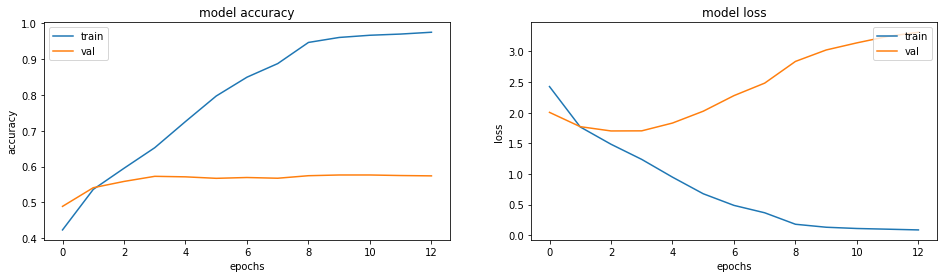

In [73]:
plt.figure(figsize=(16, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['categorical_accuracy'])
plt.plot(history.history['val_categorical_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epochs')
plt.legend(['train', 'val'], loc='upper left')

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epochs')
plt.legend(['train', 'val'], loc='upper right')

plt.show()

In [74]:
cnn_bilstm_model = tf.keras.models.load_model('cnn_bilstm_model.h5')

In [75]:
pred = cnn_bilstm_model.predict(X_test_reshaped)

print(classification_report(np.argmax(pred, axis=1), np.argmax(y_test_ohe, axis=1), target_names=labels))

                                                                                  precision    recall  f1-score   support

                                                                     Інші Подяки       0.26      0.41      0.32        66
                                              Інші технічні недоліки стану ліфту       0.48      0.54      0.51       259
                Аварійний, травмонебезпечний стан утримання об’єктів благоустрою       0.07      0.38      0.11        16
                                          Бажаючі отримати ”Картки киянина (КК)”       0.77      0.71      0.74        24
                              Будівництво /дооблаштування спортивних майданчиків       0.66      0.62      0.64        34
                                                                 Будівництво АЗС       0.66      0.46      0.54        41
                                                        Будівництво в нічний час       0.50      0.31      0.39        35
                       

## t-SNE visualization

In [76]:
from sklearn.manifold import TSNE

In [77]:
class_threshold = 1000
top_classes = target.loc[target.map(df['CallZType'].value_counts().to_dict()) > class_threshold].unique()
print(f"There are {top_classes.shape[0]} with number of accidents > {class_threshold}")

There are 25 with number of accidents > 1000


In [78]:
x_tsne, y_tsne = [], []

for vec_, label_ in zip(x_vec, target.values):
    if label_ in top_classes:
        x_tsne.append(vec_)
        y_tsne.append(label_)
len(x_tsne)

66728

In [79]:
tsne_model = TSNE(n_components=2, 
                  perplexity=40, 
                  n_iter=5000, 
                  random_state=RANDOM_SEED, 
                  metric='cosine',
                  learning_rate=200)

In [82]:
%%time

threshold = 5000

X_2d = tsne_model.fit_transform(x_tsne[:])
y = np.array(y_tsne[:])

CPU times: user 1h 17min 58s, sys: 2min 11s, total: 1h 20min 9s
Wall time: 20min 30s


In [83]:
matplot_colors = list(mcolors.BASE_COLORS.keys()) + \
                 list(mcolors.TABLEAU_COLORS.keys()) + \
                 list(mcolors.CSS4_COLORS.keys())
random_colors = np.random.choice(matplot_colors, len(top_classes), replace=False)
random_colors

array(['orangered', 'darkred', 'rebeccapurple', 'brown', 'lightgray',
       'lightgreen', 'rosybrown', 'slateblue', 'silver', 'cadetblue',
       'darkolivegreen', 'orange', 'purple', 'linen', 'darkviolet',
       'grey', 'indigo', 'palegreen', 'tab:blue', 'lightseagreen',
       'yellow', 'ivory', 'lightcoral', 'blueviolet', 'tab:olive'],
      dtype='<U20')

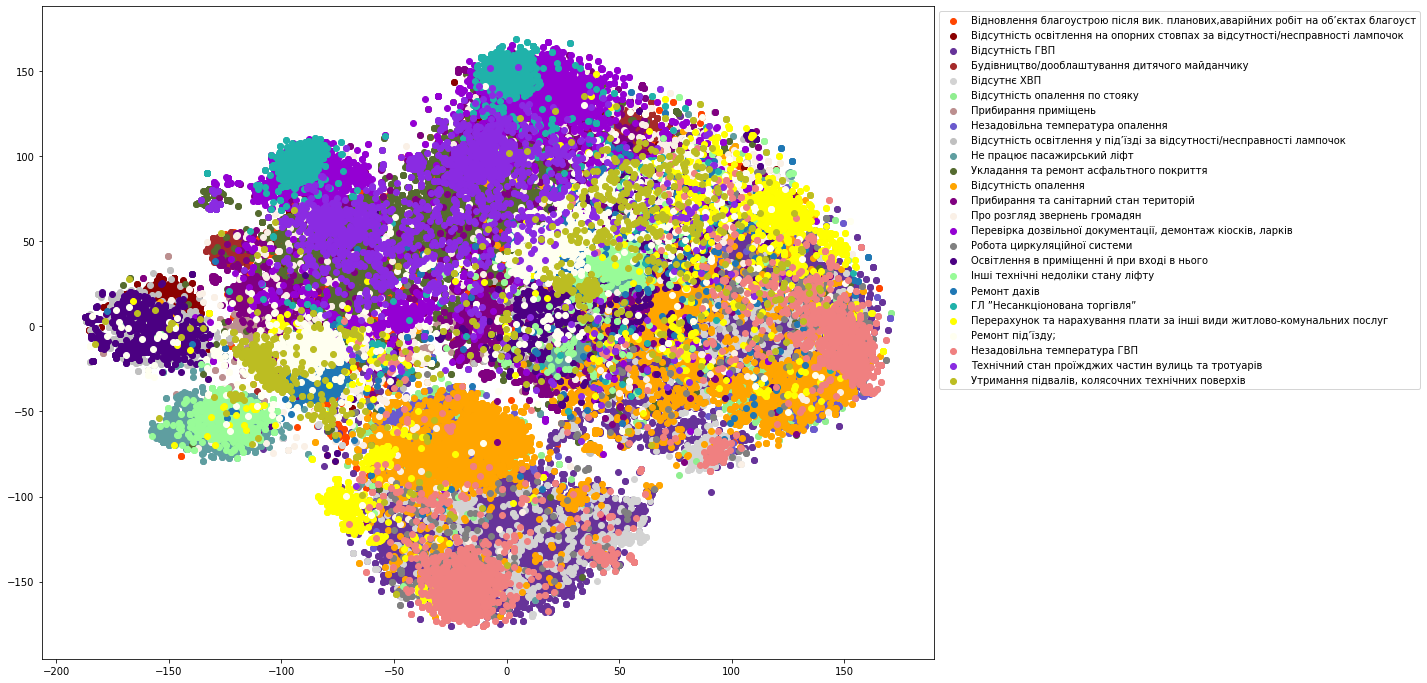

In [84]:
plt.figure(figsize=(16, 12))

for color, label in zip(random_colors, top_classes):
    plt.scatter(X_2d[y == label, 0], X_2d[y == label, 1], label=label, c=color)
plt.legend(loc='upper right', bbox_to_anchor=(1.55, 1.))
plt.show()